# Trabalho Final - Análise de Dados com Python

Integrantes:

    1) Marcelo Leopoldo e Silva de Carvalho Filho

### Enunciado

A partir dos dados housing.csv, realize toda análise exploratória necessária e prepare os dados para algoritmos de machine learning usando a Scikit-Learn. Treine um modelo de regressão linear que prediga a variável meta (median_house_value) e cujo valor de RMSE seja menor ou igual a 69000. 

### Resposta ao enunciado

In [417]:
#disable warnings
import warnings
warnings.filterwarnings('ignore')

In [418]:
# import libs
import sklearn.linear_model as L
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from functools import reduce
import pandas as P
import numpy as N
import re as R
from math import ceil
from scipy.stats import pointbiserialr


In [419]:
# plot configuration
import matplotlib.pyplot as PP
import seaborn as S

PP.style.use('seaborn-dark')

In [420]:
# helpers
o = lambda f: lambda g: lambda x: f(g(x))
fit = lambda X: lambda Y:  L.LinearRegression().fit(X, Y)
predict = lambda X: lambda R: R.predict(X)
RMSE = lambda Y: lambda P: mean_squared_error(Y, P, squared=False)
get_dummies = lambda X: P.get_dummies(X, drop_first=True)
drop_column = lambda c: lambda X: X.drop(c, axis=1)
split_sample = lambda X, **kwargs1: lambda Y, **kwargs2: train_test_split(X, Y, **{ 'test_size': 0.2, 'random_state': 42, **kwargs1, **kwargs2 })

def predictofit (S, **kwargs):
    X_train, X_test, Y_train, Y_test = S
    return predict(X_test)(fit(X_train)(Y_train))
def show_RMSE (X, Y, **kwargs):
    S = split_sample(X)(Y, **kwargs)
    X_train, X_test ,Y_train, Y_test = S
    print('RMSE: ', RMSE(Y_test)(predictofit(S, **kwargs)))

def tableIO (file):
    table = P.read_csv(file)
    table = table.fillna(table.median())
    X = table.drop(['median_house_value'], axis=1)
    Y = table['median_house_value']
    def initialXY():
        return (X.copy(), Y.copy())
    return (table.copy(), initialXY)

In [421]:
# initialize environment
table, initialXY = tableIO('housing.csv')

X, Y = initialXY()

In [422]:
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [423]:
# correlation with median_house_value
drop_column(['median_house_value'])(table).corrwith(table['median_house_value'])

longitude            -0.045967
latitude             -0.144160
housing_median_age    0.105623
total_rooms           0.134153
total_bedrooms        0.049457
population           -0.024650
households            0.065843
median_income         0.688075
dtype: float64

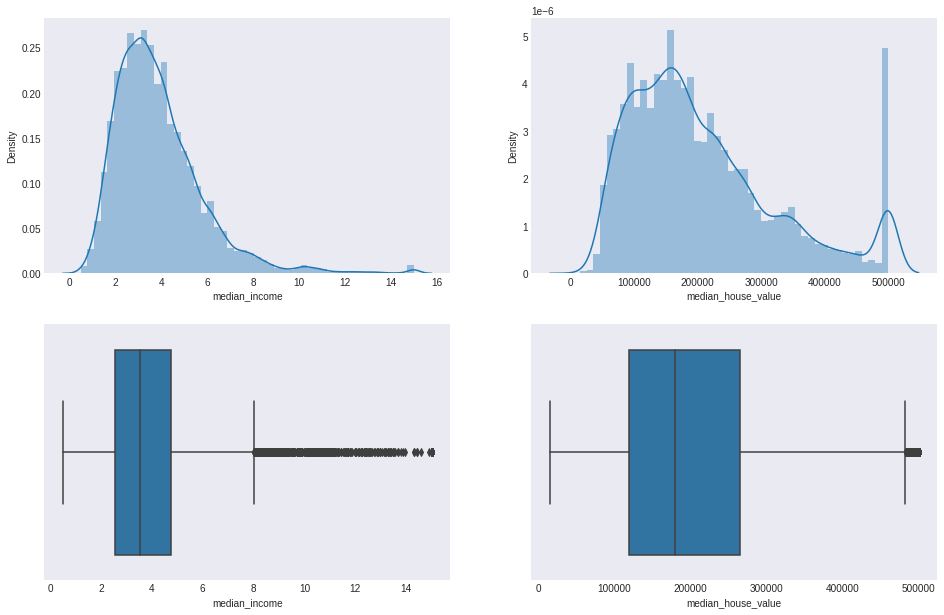

In [425]:
# Median income vs median house value
T = table.copy()
PP.figure(figsize=(16,16))
PP.subplot(3,2,1)
S.distplot(T['median_income'])
PP.subplot(3,2,2)
S.distplot(T['median_house_value'])
PP.subplot(3,2,3)
S.boxplot(T['median_income'])
PP.subplot(3,2,4)
S.boxplot(T['median_house_value'])
PP.show()


<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

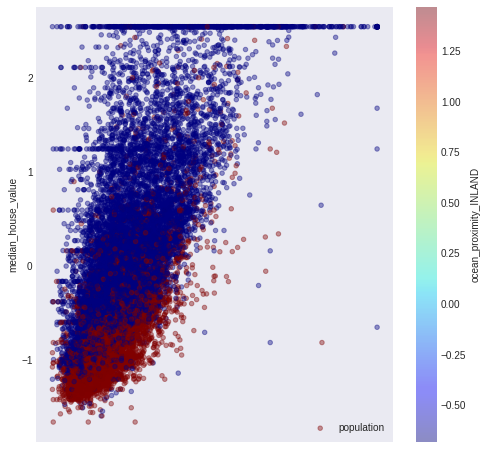

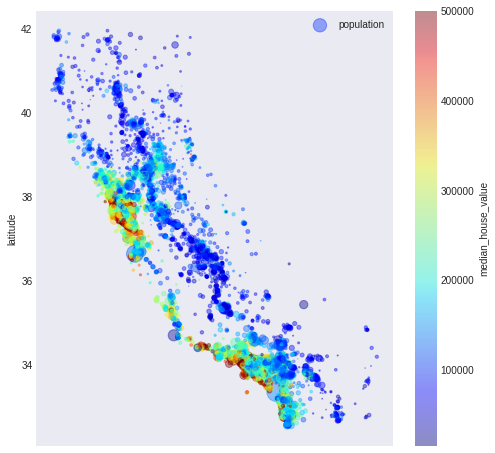

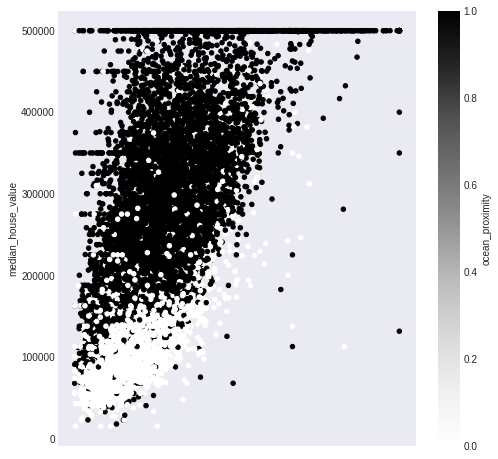

In [426]:
# Correlation between median_house_value and coordinates
T = table.copy()
TSx, TSy = (drop_column(['median_house_value'])(T), T['ocean_proximity'])
T = get_dummies(T)
T = P.DataFrame(StandardScaler().fit(T).transform(T), columns=T.columns)
itn, itt = list(StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42).split(TSx, TSy))[0]
TN, TT = (T.iloc[itn], T.iloc[itt])

TN.plot( kind="scatter"
       , figsize=(8,8)
       , x='median_income'
       , y='median_house_value'
       , alpha=0.4
       , label='population'
       , c='ocean_proximity_INLAND'
       , cmap=PP.get_cmap("jet")
)

train_set.plot(kind="scatter", figsize=(8, 8), x='longitude', y='latitude', alpha=0.4, s=train_set['population']/100, label='population', c="median_house_value", cmap=PP.get_cmap("jet"))
T = table.copy()
T['ocean_proximity'] = list(map( lambda x: 0 if x == 'INLAND' else 1,  T['ocean_proximity']))
T.plot(kind="scatter", x="median_income", y='median_house_value', c='ocean_proximity', figsize=(8,8))

# Dataset de casas na california

`housing.csv` é um dataset com casas na california e devemos fazer um modelo que consiga prever o valor mediano das casas em um quarteirão da california, dado os valores de uma linha menos o `median_house_value`. Analisando os dados apresentados assima podemos concluir que:

* **dataset**:
    * 10 colunas:
        * 9 numericas
        * 1 categorica
            * `ocean_proximity`
* **correlação com** `median_house_value`
    * `median_income`: **forte**
    * `ocean_proximity`: quanto mais proximo ao mar maior o valor da casa

## Normalização do dataset

### estratificação

Vamos estratificar o dataset por `ocean_proximity`, porque existe uma correlação entre o ultimo e `median_house_value`; e tambem porque a estratificação se da mais naturalmente com variaves categoricas, por não ser preciso qualquer conversão.

Para isso usamos `StratifiedShuffleSplit` com apenas 1 split e estratificado por `ocean_proximity

### conversão de categorica para numerica

Para converter `ocean_proximity` para numerico, usamos o `pandas.get_dummies`

### preenchimento das variaveis vazias
Para preencher os valores vazis de qualquer coluna, usamos `df.fillna(df.median())`

## Regressão Linear

Após normalizarmos os dados de conseguimos um `RSME NORMALIZADO = 0.593070613329019`, portanto abaixo do pedido no resultado.


In [427]:
# Resultado do RMSE
# T   = table
# TN  = train
# TT  = test
# TS  = Strat
# TSx = Strat x
# TSy = Strat y
T = table.copy()
TSx, TSy = (drop_column(['median_house_value'])(T), T['ocean_proximity'])
T = get_dummies(T)
T = P.DataFrame(StandardScaler().fit(T).transform(T), columns=T.columns)
itn, itt = list(StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42).split(TSx, TSy))[0]
TN, TT = (T.iloc[itn], T.iloc[itt])

get_ys = lambda T: T['median_house_value']
get_xs = drop_column(['median_house_value'])

TNx, TTx, TNy, TTy, = (get_xs(TN), get_xs(TT), get_ys(TN), get_ys(TT))

predicted = predict(TTx)(fit(TNx)(TNy))

print("RMSE: ", RMSE(TTy)(predicted))

RMSE:  0.593070613329019


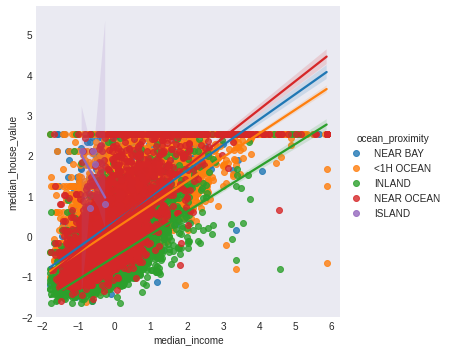

In [428]:
# Linear Regression Graph
T['ocean_proximity'] = table['ocean_proximity'].copy()
S.lmplot(x="median_income", y="median_house_value", data=T, hue='ocean_proximity');


Devido ao alto erro e pela configuração de dados, concluimos que seria melhor um outro algoritimo supervisionado, como por exemplo: randomforest, decision tree ou equivalente. 